# STOFS 3D

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/asascience-open/xarray-subset-grid/blob/main/docs/examples/stofs_3d.ipynb)

In [ ]:
# Install required libraries
# !pip install -q xarray_subset_grid@git+https://github.com/asascience-open/xarray-subset-grid.git
# !pip install -q s3fs cftime xarray cf-xarray fsspec dask h5netcdf

We use the Stofs-3d-Atl Out2d file to compute a subset selector and then reuse it to subset other files like temperature, salinity, etc.   
In this example, we reuse it for temperature.

In [2]:
import cf_xarray #noqa
import fsspec
import xarray as xr

import xarray_subset_grid

# Open the dataset from NODD s3 bucket directly
fs = fsspec.filesystem("s3", anon=True)
ds = xr.open_dataset(
    fs.open(
        "s3://noaa-nos-stofs3d-pds/STOFS-3D-Atl-shadow-VIMS/20240716/out2d_20240717.nc"
    ),
    chunks={},
    engine='h5netcdf',
    drop_variables=['nvel']
)

ds

<xarray.Dataset> Size: 4GB
Dimensions:                  (time: 24, one: 1, nSCHISM_hgrid_node: 2973769,
                              nSCHISM_hgrid_face: 5728020,
                              nSCHISM_hgrid_edge: 8701944,
                              nMaxSCHISM_hgrid_face_nodes: 4, two: 2)
Coordinates:
  * time                     (time) datetime64[ns] 192B 2024-07-17T01:00:00 ....
    SCHISM_hgrid_node_x      (nSCHISM_hgrid_node) float64 24MB dask.array<chunksize=(495629,), meta=np.ndarray>
    SCHISM_hgrid_node_y      (nSCHISM_hgrid_node) float64 24MB dask.array<chunksize=(495629,), meta=np.ndarray>
    SCHISM_hgrid_face_x      (nSCHISM_hgrid_face) float64 46MB dask.array<chunksize=(520730,), meta=np.ndarray>
    SCHISM_hgrid_face_y      (nSCHISM_hgrid_face) float64 46MB dask.array<chunksize=(520730,), meta=np.ndarray>
    SCHISM_hgrid_edge_x      (nSCHISM_hgrid_edge) float64 70MB dask.array<chunksize=(511880,), meta=np.ndarray>
    SCHISM_hgrid_edge_y      (nSCHISM_hgrid_edge) float64 70MB dask.array<chunksize=(511880,), meta=np.ndarray>
Dimensions without coordinates: one, nSCHISM_hgrid_node, nSCHISM_hgrid_face,
                                nSCHISM_hgrid_edge,
                                nMaxSCHISM_hgrid_face_nodes, two
Data variables: (12/17)
    minimum_depth            (one) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    SCHISM_hgrid             (one) |S1 1B dask.array<chunksize=(1,), meta=np.ndarray>
    crs                      (one) int32 4B dask.array<chunksize=(1,), meta=np.ndarray>
    depth                    (nSCHISM_hgrid_node) float32 12MB dask.array<chunksize=(991257,), meta=np.ndarray>
    bottom_index_node        (nSCHISM_hgrid_node) int32 12MB dask.array<chunksize=(991257,), meta=np.ndarray>
    SCHISM_hgrid_face_nodes  (nSCHISM_hgrid_face, nMaxSCHISM_hgrid_face_nodes) float64 183MB dask.array<chunksize=(1145604, 1), meta=np.ndarray>
    ...                       ...
    windSpeedX               (time, nSCHISM_hgrid_node) float32 285MB dask.array<chunksize=(1, 991257), meta=np.ndarray>
    windSpeedY               (time, nSCHISM_hgrid_node) float32 285MB dask.array<chunksize=(1, 991257), meta=np.ndarray>
    windStressX              (time, nSCHISM_hgrid_node) float32 285MB dask.array<chunksize=(1, 991257), meta=np.ndarray>
    windStressY              (time, nSCHISM_hgrid_node) float32 285MB dask.array<chunksize=(1, 991257), meta=np.ndarray>
    dryFlagElement           (time, nSCHISM_hgrid_face) float32 550MB dask.array<chunksize=(1, 954670), meta=np.ndarray>
    dryFlagSide              (time, nSCHISM_hgrid_edge) float32 835MB dask.array<chunksize=(1, 966883), meta=np.ndarray>
Attributes:
    NCO:      netCDF Operators version 4.9.7 (Homepage = http://nco.sf.net, C...
    history:  Wed Jul 17 02:17:50 2024: ncatted -a units,windSpeedY,o,c,m/s -...

Fix any inconsistencies with regards to the dataset's UGRID specifications. (Make the dataset CF compliant)

In [3]:
ds = xarray_subset_grid.grids.ugrid.assign_ugrid_topology(ds)

In [4]:
f"Dataset size: {ds.nbytes * 1.0e-9} Gb"

'Dataset size: 4.293908965 Gb'

### Example BBOX

Drawn with https://geojson.io

![image.png](example_data/image.png)

Compute the subset selection ahead of time, because STOFS doesn't include the grid in all of its output files.  
Specify the selector name for easier accessibility. (optional)

In [8]:
%%time

bbox = (-70, 40, -60, 50)
name = 'northeastUSA'

bbox_selector = ds.xsg.grid.compute_bbox_subset_selector(ds, bbox, name)
bbox_selector

CPU times: user 6.54 s, sys: 829 ms, total: 7.37 s
Wall time: 11.8 s


<class 'xarray_subset_grid.grids.ugrid.UGridSelector'> - northeastUSA

Then we can slice this dataset to make sure it works. This is FAST because the hard part is already done

In [9]:
%%time

ds_subset_control = bbox_selector.select(ds)
ds_subset_control

CPU times: user 301 ms, sys: 2.83 ms, total: 304 ms
Wall time: 301 ms


<xarray.Dataset> Size: 1GB
Dimensions:                  (time: 24, one: 1, nSCHISM_hgrid_node: 142475,
                              nSCHISM_hgrid_face: 274187,
                              nSCHISM_hgrid_edge: 8701944,
                              nMaxSCHISM_hgrid_face_nodes: 4, two: 2)
Coordinates:
  * time                     (time) datetime64[ns] 192B 2024-07-17T01:00:00 ....
    SCHISM_hgrid_node_x      (nSCHISM_hgrid_node) float64 1MB dask.array<chunksize=(7165,), meta=np.ndarray>
    SCHISM_hgrid_node_y      (nSCHISM_hgrid_node) float64 1MB dask.array<chunksize=(7165,), meta=np.ndarray>
    SCHISM_hgrid_face_x      (nSCHISM_hgrid_face) float64 2MB dask.array<chunksize=(166039,), meta=np.ndarray>
    SCHISM_hgrid_face_y      (nSCHISM_hgrid_face) float64 2MB dask.array<chunksize=(166039,), meta=np.ndarray>
    SCHISM_hgrid_edge_x      (nSCHISM_hgrid_edge) float64 70MB dask.array<chunksize=(511880,), meta=np.ndarray>
    SCHISM_hgrid_edge_y      (nSCHISM_hgrid_edge) float64 70MB dask.array<chunksize=(511880,), meta=np.ndarray>
Dimensions without coordinates: one, nSCHISM_hgrid_node, nSCHISM_hgrid_face,
                                nSCHISM_hgrid_edge,
                                nMaxSCHISM_hgrid_face_nodes, two
Data variables: (12/17)
    minimum_depth            (one) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    SCHISM_hgrid             (one) |S1 1B dask.array<chunksize=(1,), meta=np.ndarray>
    crs                      (one) int32 4B dask.array<chunksize=(1,), meta=np.ndarray>
    depth                    (nSCHISM_hgrid_node) float32 570kB dask.array<chunksize=(142475,), meta=np.ndarray>
    bottom_index_node        (nSCHISM_hgrid_node) int32 570kB dask.array<chunksize=(142475,), meta=np.ndarray>
    SCHISM_hgrid_face_nodes  (nSCHISM_hgrid_face, nMaxSCHISM_hgrid_face_nodes) float64 9MB dask.array<chunksize=(265743, 1), meta=np.ndarray>
    ...                       ...
    windSpeedX               (time, nSCHISM_hgrid_node) float32 14MB dask.array<chunksize=(1, 142475), meta=np.ndarray>
    windSpeedY               (time, nSCHISM_hgrid_node) float32 14MB dask.array<chunksize=(1, 142475), meta=np.ndarray>
    windStressX              (time, nSCHISM_hgrid_node) float32 14MB dask.array<chunksize=(1, 142475), meta=np.ndarray>
    windStressY              (time, nSCHISM_hgrid_node) float32 14MB dask.array<chunksize=(1, 142475), meta=np.ndarray>
    dryFlagElement           (time, nSCHISM_hgrid_face) float32 26MB dask.array<chunksize=(1, 253878), meta=np.ndarray>
    dryFlagSide              (time, nSCHISM_hgrid_edge) float32 835MB dask.array<chunksize=(1, 966883), meta=np.ndarray>
Attributes:
    NCO:      netCDF Operators version 4.9.7 (Homepage = http://nco.sf.net, C...
    history:  Wed Jul 17 02:17:50 2024: ncatted -a units,windSpeedY,o,c,m/s -...

In [10]:
f"Dataset size: {ds_subset_control.nbytes * 1.0e-9} Gb"

'Dataset size: 1.2661721650000002 Gb'

We can save the selector to disk. (as a pickle file)  
Use the `save_to_bytes` function to return the selector as a bytes object.  
To get a unique filename, you can use the `get_hashname` function.

In [11]:
selector_bytes = bbox_selector.save_to_bytes()
filepath = bbox_selector.get_hashname()

with open(filepath, 'wb') as f:
    f.write(selector_bytes)

'northeastUSA_bb3d126e.pkl'

Open a selector using a bytes object.
This retains the subclass of the selector (i.e, UGridSelector, SGridSelector, etc)

In [12]:
from xarray_subset_grid import Selector

selector_bytes = open(filepath, 'rb').read()

loaded_bbox_selector = Selector(selector_bytes)

loaded_bbox_selector

<class 'xarray_subset_grid.grids.ugrid.UGridSelector'> - northeastUSA

Test if both the selectors are same.

In [13]:
bbox_selector == loaded_bbox_selector

True

Now we can load in a STOFS 3D - temperature file from a different day and subset it!

In [14]:
ds_temp = xr.open_dataset(
    fs.open(
        "s3://noaa-nos-stofs3d-pds/STOFS-3D-Atl-shadow-VIMS/20240728/temperature_20240728.nc"
    ),
    chunks={},
    drop_variables=['nvel']
)

ds_temp = xarray_subset_grid.grids.ugrid.assign_ugrid_topology(ds_temp)
ds

<xarray.Dataset> Size: 4GB
Dimensions:                  (time: 24, one: 1, nSCHISM_hgrid_node: 2973769,
                              nSCHISM_hgrid_face: 5728020,
                              nSCHISM_hgrid_edge: 8701944,
                              nMaxSCHISM_hgrid_face_nodes: 4, two: 2)
Coordinates:
  * time                     (time) datetime64[ns] 192B 2024-07-17T01:00:00 ....
    SCHISM_hgrid_node_x      (nSCHISM_hgrid_node) float64 24MB dask.array<chunksize=(495629,), meta=np.ndarray>
    SCHISM_hgrid_node_y      (nSCHISM_hgrid_node) float64 24MB dask.array<chunksize=(495629,), meta=np.ndarray>
    SCHISM_hgrid_face_x      (nSCHISM_hgrid_face) float64 46MB dask.array<chunksize=(520730,), meta=np.ndarray>
    SCHISM_hgrid_face_y      (nSCHISM_hgrid_face) float64 46MB dask.array<chunksize=(520730,), meta=np.ndarray>
    SCHISM_hgrid_edge_x      (nSCHISM_hgrid_edge) float64 70MB dask.array<chunksize=(511880,), meta=np.ndarray>
    SCHISM_hgrid_edge_y      (nSCHISM_hgrid_edge) float64 70MB dask.array<chunksize=(511880,), meta=np.ndarray>
Dimensions without coordinates: one, nSCHISM_hgrid_node, nSCHISM_hgrid_face,
                                nSCHISM_hgrid_edge,
                                nMaxSCHISM_hgrid_face_nodes, two
Data variables: (12/17)
    minimum_depth            (one) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    SCHISM_hgrid             (one) |S1 1B dask.array<chunksize=(1,), meta=np.ndarray>
    crs                      (one) int32 4B dask.array<chunksize=(1,), meta=np.ndarray>
    depth                    (nSCHISM_hgrid_node) float32 12MB dask.array<chunksize=(991257,), meta=np.ndarray>
    bottom_index_node        (nSCHISM_hgrid_node) int32 12MB dask.array<chunksize=(991257,), meta=np.ndarray>
    SCHISM_hgrid_face_nodes  (nSCHISM_hgrid_face, nMaxSCHISM_hgrid_face_nodes) float64 183MB dask.array<chunksize=(1145604, 1), meta=np.ndarray>
    ...                       ...
    windSpeedX               (time, nSCHISM_hgrid_node) float32 285MB dask.array<chunksize=(1, 991257), meta=np.ndarray>
    windSpeedY               (time, nSCHISM_hgrid_node) float32 285MB dask.array<chunksize=(1, 991257), meta=np.ndarray>
    windStressX              (time, nSCHISM_hgrid_node) float32 285MB dask.array<chunksize=(1, 991257), meta=np.ndarray>
    windStressY              (time, nSCHISM_hgrid_node) float32 285MB dask.array<chunksize=(1, 991257), meta=np.ndarray>
    dryFlagElement           (time, nSCHISM_hgrid_face) float32 550MB dask.array<chunksize=(1, 954670), meta=np.ndarray>
    dryFlagSide              (time, nSCHISM_hgrid_edge) float32 835MB dask.array<chunksize=(1, 966883), meta=np.ndarray>
Attributes:
    NCO:      netCDF Operators version 4.9.7 (Homepage = http://nco.sf.net, C...
    history:  Wed Jul 17 02:17:50 2024: ncatted -a units,windSpeedY,o,c,m/s -...

And then slice it with the same selector!

In [15]:
%%time

ds_temp_subset = loaded_bbox_selector.select(ds_temp)
ds_temp_subset

CPU times: user 171 ms, sys: 129 µs, total: 172 ms
Wall time: 172 ms


<xarray.Dataset> Size: 965MB
Dimensions:                  (time: 24, one: 1, nSCHISM_hgrid_node: 142475,
                              nSCHISM_hgrid_face: 274187,
                              nSCHISM_hgrid_edge: 8701944,
                              nMaxSCHISM_hgrid_face_nodes: 4, two: 2,
                              nSCHISM_vgrid_layers: 49)
Coordinates:
  * time                     (time) datetime64[ns] 192B 2024-07-28T01:00:00 ....
    SCHISM_hgrid_node_x      (nSCHISM_hgrid_node) float64 1MB dask.array<chunksize=(7165,), meta=np.ndarray>
    SCHISM_hgrid_node_y      (nSCHISM_hgrid_node) float64 1MB dask.array<chunksize=(7165,), meta=np.ndarray>
Dimensions without coordinates: one, nSCHISM_hgrid_node, nSCHISM_hgrid_face,
                                nSCHISM_hgrid_edge,
                                nMaxSCHISM_hgrid_face_nodes, two,
                                nSCHISM_vgrid_layers
Data variables:
    minimum_depth            (one) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    SCHISM_hgrid             (one) |S1 1B dask.array<chunksize=(1,), meta=np.ndarray>
    crs                      (one) int32 4B dask.array<chunksize=(1,), meta=np.ndarray>
    depth                    (nSCHISM_hgrid_node) float32 570kB dask.array<chunksize=(142475,), meta=np.ndarray>
    bottom_index_node        (nSCHISM_hgrid_node) int32 570kB dask.array<chunksize=(142475,), meta=np.ndarray>
    SCHISM_hgrid_face_x      (nSCHISM_hgrid_face) float64 2MB dask.array<chunksize=(166039,), meta=np.ndarray>
    SCHISM_hgrid_face_y      (nSCHISM_hgrid_face) float64 2MB dask.array<chunksize=(166039,), meta=np.ndarray>
    SCHISM_hgrid_edge_x      (nSCHISM_hgrid_edge) float64 70MB dask.array<chunksize=(511880,), meta=np.ndarray>
    SCHISM_hgrid_edge_y      (nSCHISM_hgrid_edge) float64 70MB dask.array<chunksize=(511880,), meta=np.ndarray>
    SCHISM_hgrid_face_nodes  (nSCHISM_hgrid_face, nMaxSCHISM_hgrid_face_nodes) float64 9MB dask.array<chunksize=(265743, 1), meta=np.ndarray>
    SCHISM_hgrid_edge_nodes  (nSCHISM_hgrid_edge, two) float64 139MB dask.array<chunksize=(1740389, 1), meta=np.ndarray>
    temperature              (time, nSCHISM_hgrid_node, nSCHISM_vgrid_layers) float32 670MB dask.array<chunksize=(1, 142475, 49), meta=np.ndarray>
Attributes:
    NCO:      netCDF Operators version 4.9.7 (Homepage = http://nco.sf.net, C...
    history:  Mon Jul 29 02:42:02 2024: ncatted -a units,temperature,o,c,Degr...

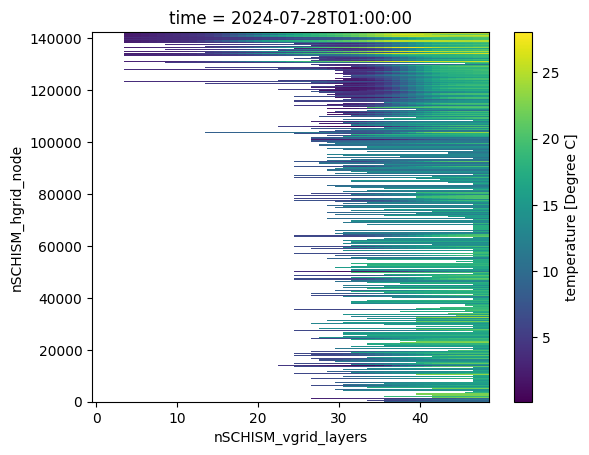

In [17]:
ds_temp_subset.isel(time=0).temperature.plot()